In [2]:
from joblib import load
import os
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import useful_functions as uf
import pandas as pd
import coin_circle_detector as ccd

# Cargar el modelo guardado
modelo_cargado = load('modelo_random_forest.joblib')

In [3]:
images = [f for f in os.listdir('training') if f.endswith('.jpg')]
img_files_filter = list(filter(lambda x: 'test' in x, images))
uf.sort_list_of_fs_by_ascending_number(img_files_filter, r_pattern='image_')


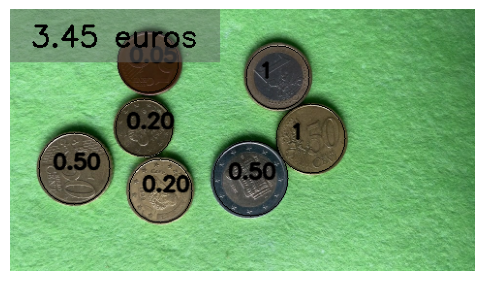

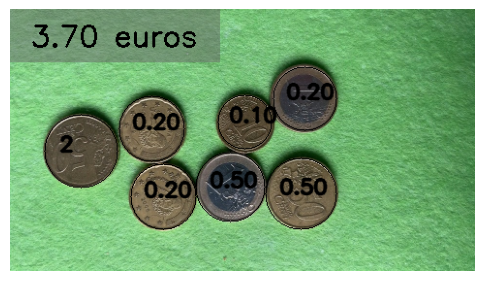

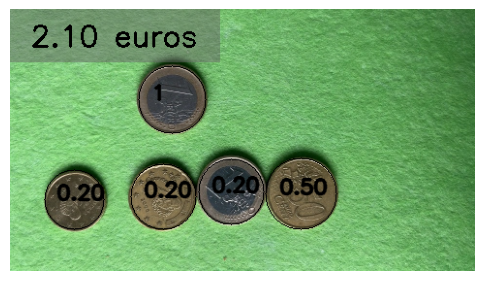

In [4]:
def image_result(img, circulos, labels):
    total = sum(map(float, labels))
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = .7
    color = (0, 0, 0)
    thickness = 2
    img_ = img.copy()
    for n, i in enumerate(circulos):
        cv2.circle(img_, (i[0], i[1]), i[2], (0, 0, 0), 1)
        cv2.putText(img_, labels[n], (i[0]-int(i[2]*0.6),i[1]), font, 
                    fontScale, color, thickness, cv2.LINE_AA)
        
    img_ = uf.imagen_con_texto(img_, f'{total:.2f} euros', posicion= [[0, 0], [.45, .2]])

    f, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    plt.show()

for img_n in img_files_filter[:3]:
    monedas = ['0.05', '0.10', '0.20', '0.50', '1', '2']
    _, _, circulos  = ccd.alg_1(f'training/{img_n}', params={'dp':1.3, 'param2':17}, vis_result=False)
    radio_values_df = pd.DataFrame({'radio': circulos[:,2]})
    ################
    colores_monedas = {}
    colores = []

    img = cv2.imread(f'training/{img_n}')
    img = cv2.resize(img, None, fx = .5, fy=.5)
    imgPre = cv2.GaussianBlur(img, (7,7), 7)
    imgPre = cv2.medianBlur(imgPre, 7)
    for cir in circulos:
            imgPre_ = imgPre.copy()
            color = uf.get_color_from_circle(imgPre_, cir[:2], cir[2], vis= False)
            valor_h = cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_BGR2HSV)[0][0][0]
            valor_s = cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_BGR2HSV)[0][0][1]
            valor_v = cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_BGR2HSV)[0][0][2]
            colores.append([valor_h, valor_s, valor_v])

    colores_df = pd.DataFrame(colores, columns=['h','s','v'])
    image_data = pd.concat([colores_df, radio_values_df], axis=1)
    ################
    predicciones = modelo_cargado.predict(image_data)
    labels = [monedas[i] for i in predicciones]
    image_result(img, circulos, labels)
    
    
    